In [1]:
import findspark
findspark.init()

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import length
from pyspark.sql.types import StringType

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [4]:
spark = SparkSession.builder.appName('power_plant').getOrCreate()

In [5]:
# Load data
pd_data = pd.read_excel("../../Data/CCPP/Folds5x2_pp.xlsx")

In [6]:
pd_data.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [7]:
pd_data.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


In [8]:
pd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [9]:
def ExploreContVariable(column):
    data = pd_data[column]
    plt.figure(figsize = (16,6))
    
    plt.subplot(1,2,1)
    sns.histplot(data, kde=True)
    
    plt.subplot(1,2,2)
    data.plot.box()
    
    plt.tight_layout()
    plt.show()
    
    print('Skew: ',data.skew())

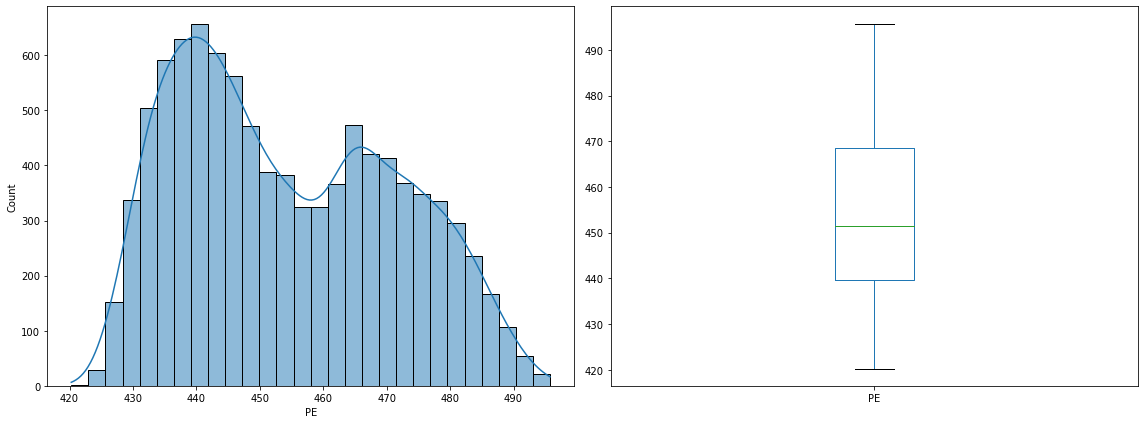

Skew:  0.30650943542040243


In [10]:
ExploreContVariable('PE')

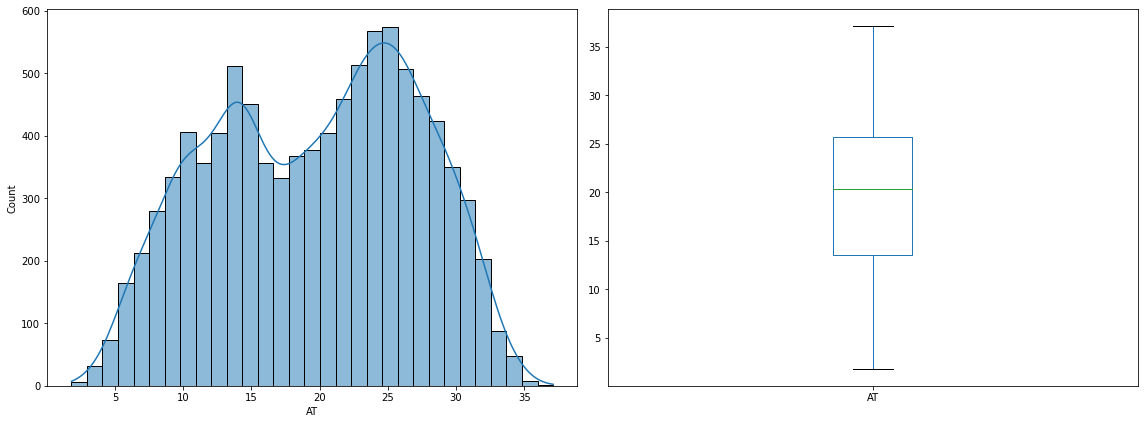

Skew:  -0.13639304947492412


In [11]:
ExploreContVariable('AT')

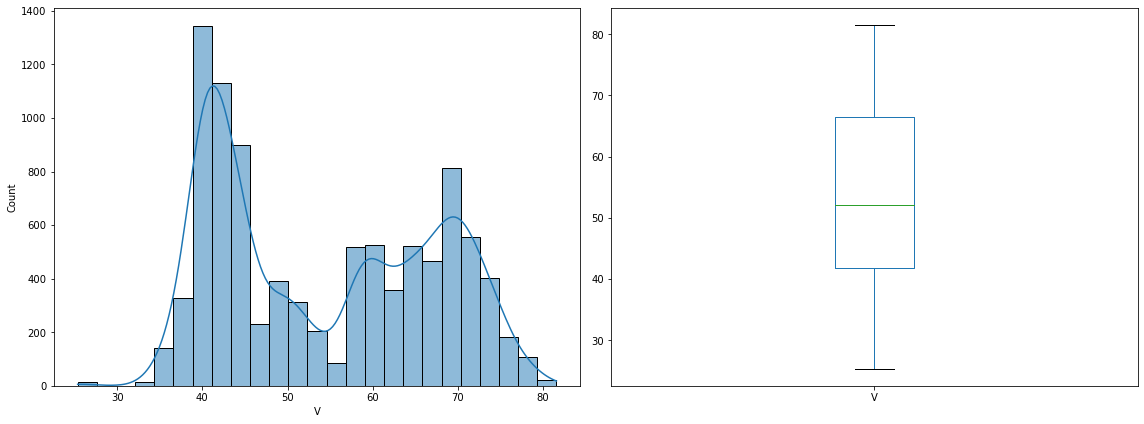

Skew:  0.1985210113667618


In [12]:
ExploreContVariable('V')

### PE, AT, V không có outliers

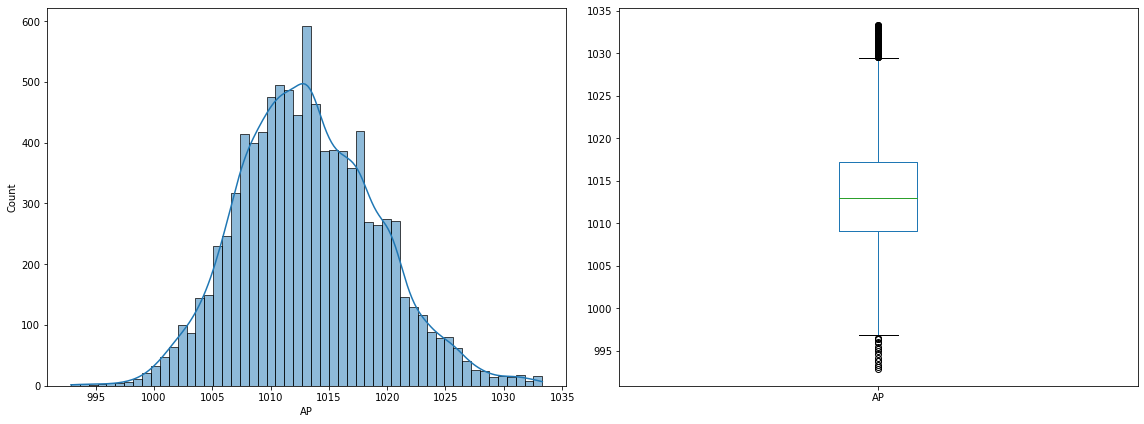

Skew:  0.26544469358258616


In [13]:
ExploreContVariable('AP')

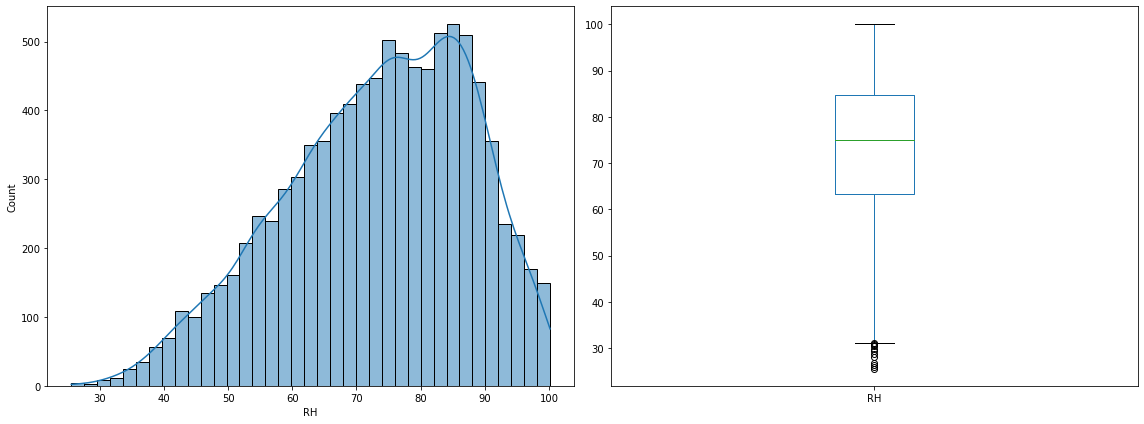

Skew:  -0.4318387491833358


In [14]:
ExploreContVariable('RH')

### AP và RH có outliers

In [15]:
def caculate_outliers(column):
    data = pd_data[column]
    Q1 = np.percentile(data.dropna(), 25)
    Q3 = np.percentile(data.dropna(), 75)
    IQR = scipy.stats.iqr(data.dropna())
    O_upper = Q3 + 1.5*IQR
    O_lower = Q1 - 1.5*IQR
    n_O_upper = data[data > O_upper].shape[0]
    n_O_lower = data[data < O_lower].shape[0]
    print('Percent of outlier: ', (n_O_lower + n_O_upper)*100/data.shape[0])
    
    return O_upper, O_lower

In [16]:
AP_o_up, AP_o_l = caculate_outliers('AP')

Percent of outlier:  0.919732441471572


In [17]:
RH_o_up, RH_o_l = caculate_outliers('RH')

Percent of outlier:  0.1254180602006689


### Loại bỏ outlier

In [18]:
pd_data = pd_data[((pd_data['AP']) <= AP_o_up) & ((pd_data['AP']) >= AP_o_l)]
pd_data = pd_data[((pd_data['RH']) <= RH_o_up) & ((pd_data['RH']) >= RH_o_l)]

In [19]:
data = spark.createDataFrame(pd_data)

In [20]:
assembler = VectorAssembler(inputCols=['AT', 'V', 'AP', 'RH'], outputCol='features')

In [21]:
output = assembler.transform(data)

In [22]:
output.select('features', 'PE').show(10)

+--------------------+------+
|            features|    PE|
+--------------------+------+
|[14.96,41.76,1024...|463.26|
|[25.18,62.96,1020...|444.37|
|[5.11,39.4,1012.1...|488.56|
|[20.86,57.32,1010...|446.48|
|[10.82,37.5,1009....| 473.9|
|[26.27,59.44,1012...|443.67|
|[15.89,43.96,1014...|467.35|
|[9.48,44.71,1019....|478.42|
|[14.64,45.0,1021....|475.98|
|[11.74,43.56,1015...| 477.5|
+--------------------+------+
only showing top 10 rows



In [23]:
train_data, test_data = output.randomSplit([0.8, 0.2])

In [24]:
final_data = output.select('features', 'PE')

In [25]:
# Create a Linear Regression Model object
lr = LinearRegression(labelCol='PE')
# Fit the model to the data and call this model lrModel
lrModel = lr.fit(train_data)
# Print the coeffecients and intercept for linear regression
print('Coefficients: {} \nIntefercept {}'.format(lrModel.coefficients, lrModel.intercept))

Coefficients: [-1.972083245275455,-0.2360481203343735,0.0705154784692849,-0.15711661244553177] 
Intefercept 445.99018946646197


In [26]:
test_results = lrModel.evaluate(test_data)

In [27]:
print('RMSE: {}'.format(test_results.rootMeanSquaredError))
print('MSE: {}'.format(test_results.meanSquaredError))
print('R2: {}'.format(test_results.r2))

RMSE: 4.4945257875439015
MSE: 20.200762054897126
R2: 0.9286160422246242
